<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/3rd_week_note_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from pathlib import Path

import torch
import torchaudio


In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
# !는 주피터에서 터미널 명령어를 사용할때 붙임
# python이 아닌 OS (Linux)에 명령을 내리고 싶을 때 실행


--2024-03-25 04:33:43--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|173.194.193.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  14.5MB/s    in 5.5s    

2024-03-25 04:33:49 (60.9 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
# 압축 풀기
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
meta = json.load(open('nsynth-test/examples.json'))
len(meta)

4096

In [5]:
# 데이터셋이 어떻게 구성돼있는지 보기
list(meta.keys())[:5]

['bass_synthetic_068-049-025',
 'keyboard_electronic_001-021-127',
 'guitar_acoustic_010-066-100',
 'reed_acoustic_037-068-127',
 'flute_acoustic_002-077-100']

In [6]:
meta['bass_synthetic_068-049-025']

{'qualities': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'pitch': 49,
 'note': 217499,
 'instrument_source_str': 'synthetic',
 'velocity': 25,
 'instrument_str': 'bass_synthetic_068',
 'instrument': 656,
 'sample_rate': 16000,
 'qualities_str': ['dark'],
 'instrument_source': 2,
 'note_str': 'bass_synthetic_068-049-025',
 'instrument_family': 0,
 'instrument_family_str': 'bass'}

In [7]:
# 메타의 키 이름이 파일 이름
fn = 'bass_synthetic_068-049-025' + '.wav'
audio_dir = Path('/content/nsynth-test/audio')

# audio directory 가 존재하는지 확인
audio_dir.exists()

True

In [8]:
audio_fn = audio_dir / fn
audio_fn, audio_fn.exists()

(PosixPath('/content/nsynth-test/audio/bass_synthetic_068-049-025.wav'), True)

In [9]:
import IPython.display as ipd

y, sr = torchaudio.load(audio_fn) # torchaudio.laod returns (wavesamples, sampling_rate)
ipd.Audio(y, rate=sr)

In [10]:
# check metadata and file consistency

fns = sorted(list(meta.keys()))
fns[:10]

['bass_electronic_018-022-100',
 'bass_electronic_018-023-025',
 'bass_electronic_018-023-075',
 'bass_electronic_018-023-127',
 'bass_electronic_018-024-025',
 'bass_electronic_018-024-100',
 'bass_electronic_018-026-025',
 'bass_electronic_018-026-075',
 'bass_electronic_018-026-127',
 'bass_electronic_018-027-075']

In [11]:
# !mv nsynth-test/audio/bass_electronic_018-026-127.wav nsynth-test/
!mv nsynth-test/bass_electronic_018-026-127.wav nsynth-test/audio/

mv: cannot stat 'nsynth-test/bass_electronic_018-026-127.wav': No such file or directory


In [12]:
# for every filename, check the file exists
for fn in fns:
  does_exist = (audio_dir / fn).with_suffix('.wav').exists()
  assert does_exist, f"{fn} does not exist"

In [13]:
# Convert audio to spectrogram
y.shape # [1, T] . SR: 16000, Duration: 4

torch.Size([1, 64000])

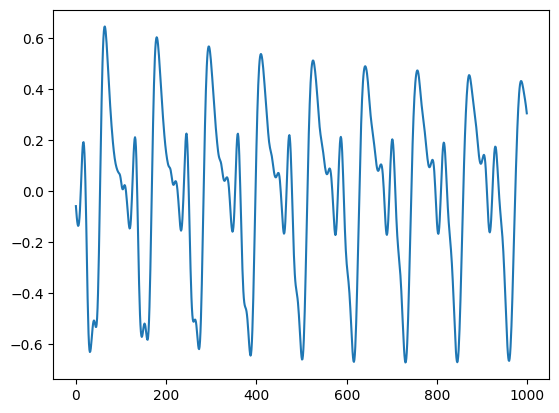

In [14]:
import matplotlib.pyplot as plt
plt.plot(y[0, 1000:2000]) # If you select single value in sepcific dimension, that dimension disappears

In [15]:
# Convert waveform to spectrogram using torchaudio

spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512)

spec = spec_converter(y)

In [16]:
spec.shape # num channel of input x num frequency bin x num time bin
# num frequency bin = n_fft // 2 + 1


torch.Size([1, 513, 126])

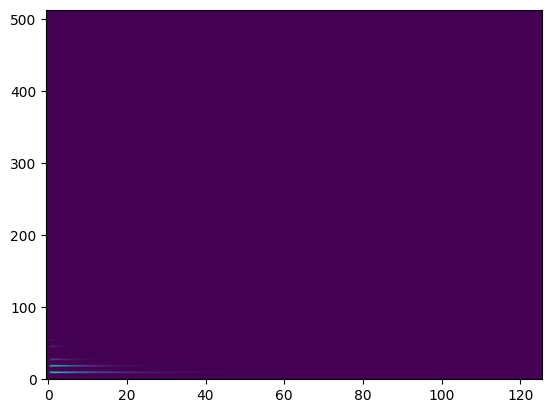

In [17]:
plt.imshow(spec[0], aspect='auto', origin='lower')

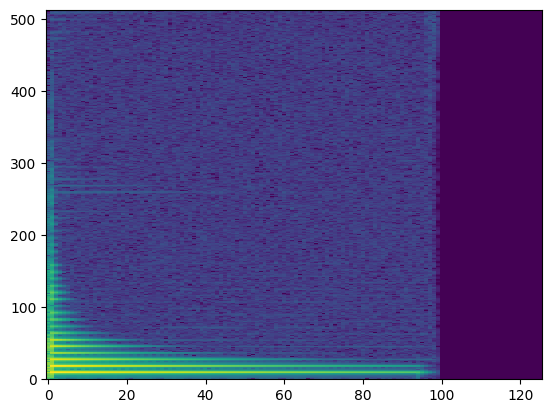

In [18]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec[0], aspect='auto', origin='lower', interpolation='none')

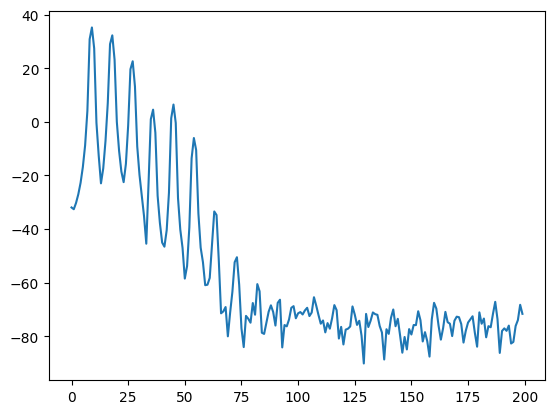

In [19]:
time_idx = 10
spectrum = db_spec[0, :200, time_idx] # select 0th channel, all frequency, time-idx-th time frame
plt.plot(spectrum)

torch.Size([513, 80])


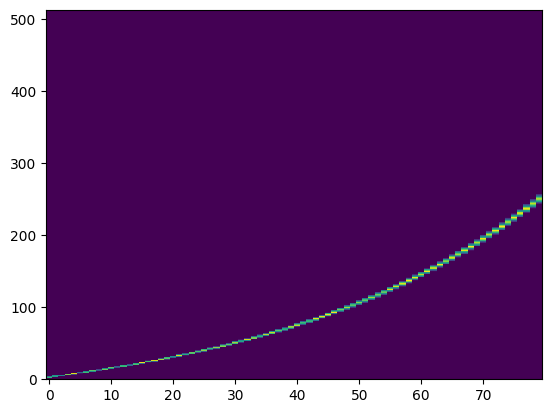

In [20]:
# compress frequency scale to log scale
mel_scale = torchaudio.transforms.MelScale(n_mels=80, sample_rate=16000, f_min=20, f_max=4000, n_stft=513)

print(mel_scale.fb.shape)
plt.imshow(mel_scale.fb, aspect='auto', origin='lower', interpolation='none')

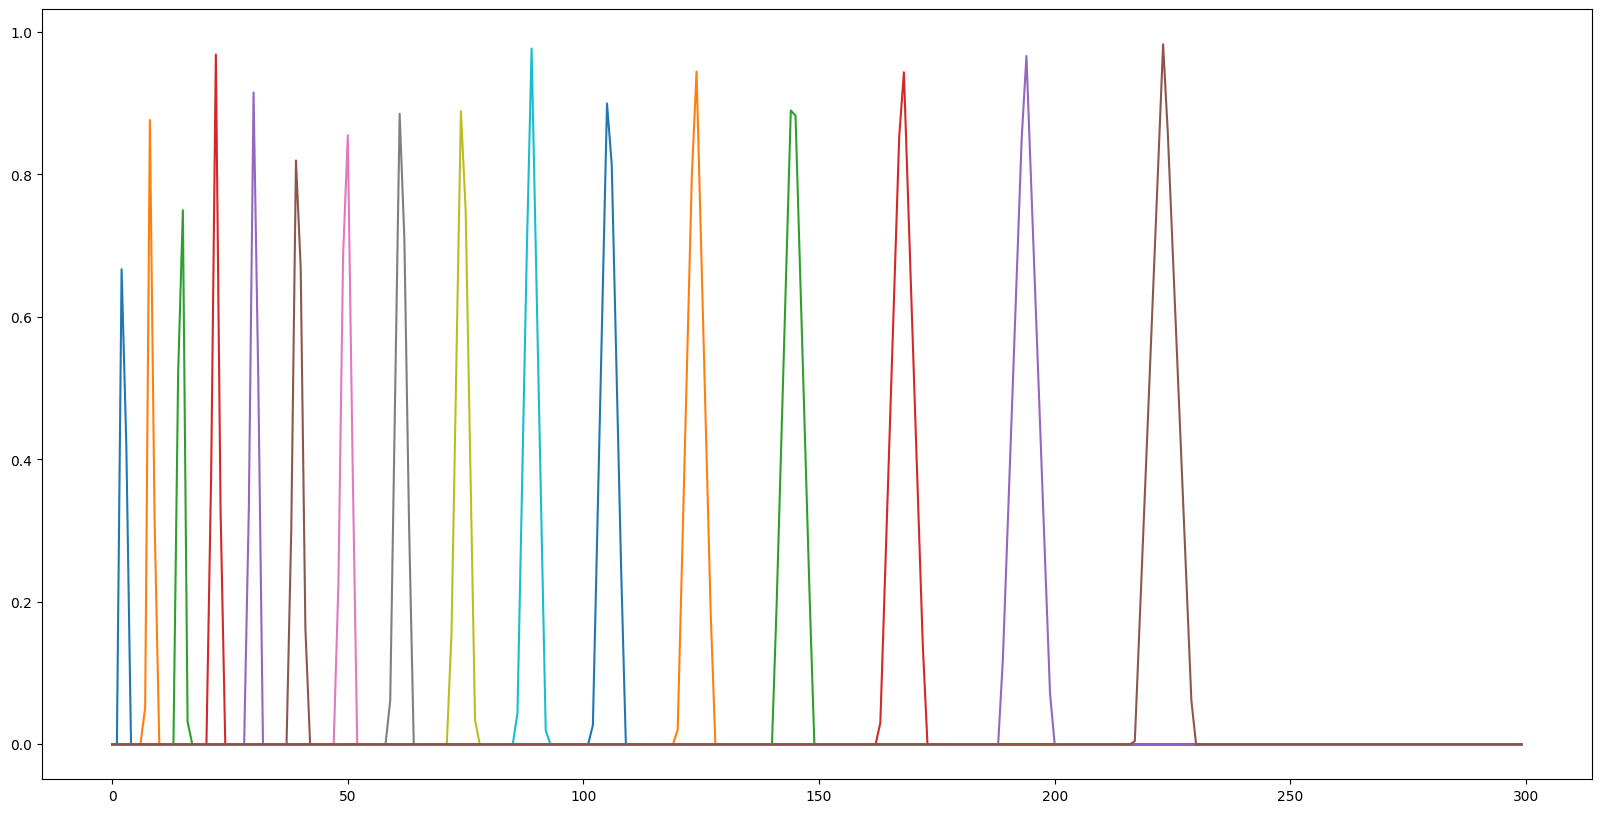

In [21]:
plt.figure(figsize=(20, 10))

for i in range(0, mel_scale.fb.shape[1], 5):
  plt.plot(mel_scale.fb[:300, i])



In [22]:
mel_spec = torch.mm(mel_scale.fb.T, spec[0])
spec.shape, mel_scale.fb.shape, mel_spec.shape

(torch.Size([1, 513, 126]), torch.Size([513, 80]), torch.Size([80, 126]))

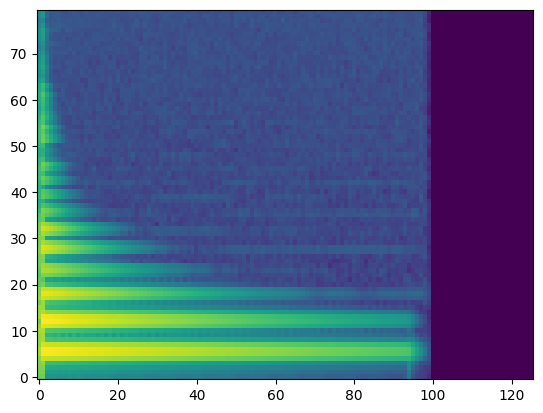

In [23]:
mel_db_spec = db_converter(mel_spec)

plt.imshow(mel_db_spec, origin='lower', aspect='auto', interpolation='none')

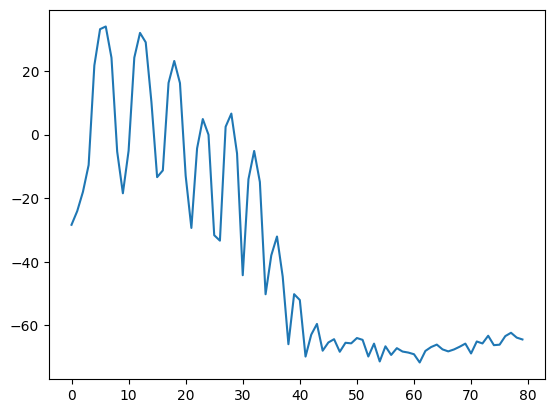

In [24]:
time_idx = 10
spectrum = mel_db_spec[:, time_idx] # select 0th channel, all frequency, time-idx-th time frame
plt.plot(spectrum)

In [25]:
mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80)

class MelDbConverter(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mel_conv = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80)
    self.db_conv = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db_conv(self.mel_conv(x))

mel_db_conv = MelDbConverter()
mel_db_conv(y).shape

torch.Size([1, 80, 126])

## Make sine wave

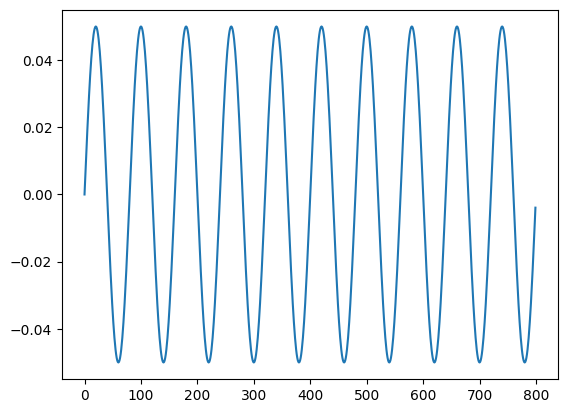

In [26]:
from math import pi

freq = 200
sampling_rate = 16000
dur=4
def make_sine_wave(freq, sampling_rate, dur=4):
  total_duration_in_sample = sampling_rate * dur
  time_in_sec = torch.arange(total_duration_in_sample) / sampling_rate
  time_in_sec

  # 1 period of angle = 2 * pi
  # 220 period of angle = 2 * pi * 220 / sec

  angular_speed =  2 * pi * freq  # angle / sec

  accumulated_angle = time_in_sec * angular_speed  # 거리 = 속도 x 시간
  sine_wave = torch.sin(accumulated_angle) / 20
  return sine_wave

sine_wave = make_sine_wave(freq, sampling_rate)
plt.plot(sine_wave[:800])

# 800 이 0.05초에 해당한다면
# 800 샘플 동안 11번 진동하면 우리가 듣는 주파수: 11 / 0.05 = 11 * 20 = 220
# 800 이 0.1초에 해당한다면 ~= sampling rate = 8000
# 11 / 0.1 = 11 * 10 = 110

In [27]:
two_waves = make_sine_wave(freq, sampling_rate) +make_sine_wave(freq*1.5, sampling_rate) + make_sine_wave(freq * 2, sampling_rate)
ipd.Audio(two_waves, rate=16000, normalize=False)

In [28]:
ipd.Audio(sine_wave, rate=9000, normalize=False)

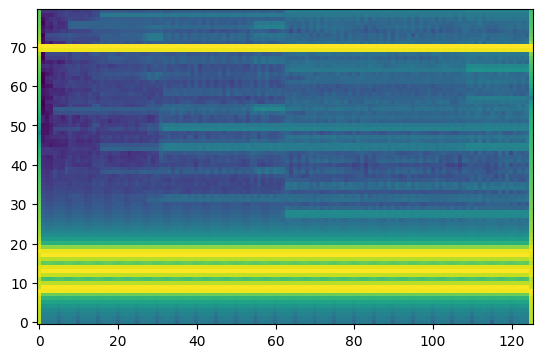

In [29]:
two_waves += make_sine_wave(3000, sampling_rate)

plt.imshow(mel_db_conv(two_waves), origin='lower')

In [30]:
# fns
audio_fns = []
for fn in fns:
  audio_fn = (audio_dir / fn).with_suffix('.wav')
  assert audio_fn.exists()
  audio_fns.append(audio_fn)
audio_fns = [(audio_dir / fn).with_suffix('.wav') for fn in fns]

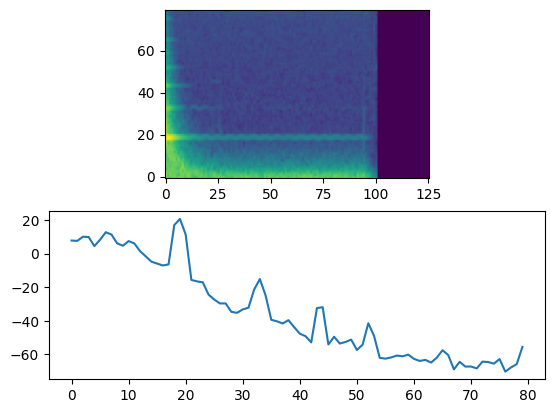

In [31]:
sample_idx = 600
audio_fn = audio_fns[sample_idx]

y, sr = torchaudio.load(audio_fn)

ipd.display(ipd.Audio(y, rate=sr, normalize=False))
mel_spec = mel_db_conv(y[0])
plt.subplot(2, 1, 1) # num_rows, num_columns, current_idx
plt.imshow(mel_spec, origin='lower')
plt.subplot(2, 1, 2)
plt.plot(mel_spec[:, 5])

In [32]:
# 80차원 벡터를 받아서, N개의 가능한 음고 후보 각각에 대한 확률 분포를 계산


In [33]:
total_pitches = []
for value in meta.values():
  # value: dict
  pitch = value['pitch']
  total_pitches.append(pitch)
total_pitches = sorted(list(set(total_pitches)))
max(total_pitches), len(total_pitches)
# 총 120개의 pitch class가 있다고 가정

(119, 106)

In [ ]:
total_pitches

In [35]:
spectrum = mel_spec[:, 5] / 100
spectrum

tensor([ 0.0772,  0.0750,  0.0998,  0.0981,  0.0439,  0.0817,  0.1266,  0.1127,
         0.0603,  0.0463,  0.0738,  0.0601,  0.0143, -0.0169, -0.0485, -0.0600,
        -0.0713, -0.0649,  0.1688,  0.2058,  0.1127, -0.1575, -0.1660, -0.1713,
        -0.2443, -0.2738, -0.2970, -0.2970, -0.3471, -0.3529, -0.3326, -0.3226,
        -0.2143, -0.1518, -0.2493, -0.3945, -0.4035, -0.4164, -0.3965, -0.4379,
        -0.4770, -0.4918, -0.5289, -0.3248, -0.3194, -0.5412, -0.4951, -0.5355,
        -0.5263, -0.5123, -0.5740, -0.5422, -0.4147, -0.4897, -0.6208, -0.6255,
        -0.6182, -0.6073, -0.6115, -0.6017, -0.6267, -0.6390, -0.6328, -0.6486,
        -0.6195, -0.5754, -0.6041, -0.6895, -0.6443, -0.6726, -0.6723, -0.6836,
        -0.6432, -0.6457, -0.6553, -0.6279, -0.7028, -0.6779, -0.6582, -0.5555])

In [36]:
import torch.nn as nn

torch.manual_seed(0)
layer = nn.Linear(80, 1) # 80차원의 벡터를 받아서, 1개의 값을 예측
# 1개의 값: 하나의 음고 클래스의 확률
print(layer.weight)
layer(spectrum)

Parameter containing:
tensor([[-0.0008,  0.0600, -0.0920, -0.0823, -0.0431,  0.0300, -0.0022,  0.0886,
         -0.0099,  0.0296, -0.0338, -0.0220, -0.1068, -0.0740, -0.0461,  0.0041,
          0.0442,  0.0671, -0.0758, -0.0487,  0.0406,  0.0928, -0.0230,  0.0837,
         -0.0180,  0.0118,  0.1012, -0.1037, -0.0704, -0.0283, -0.0436,  0.0966,
         -0.0725, -0.0515, -0.0781, -0.1047, -0.0653,  0.0961,  0.0499,  0.0542,
          0.0059, -0.0573,  0.0189, -0.1044, -0.0808, -0.0576,  0.0705,  0.0656,
         -0.0496, -0.0040,  0.0715,  0.1111,  0.0444,  0.0151,  0.0750, -0.0658,
          0.0208, -0.0867, -0.0775, -0.0578,  0.0506,  0.0450, -0.0662,  0.0338,
          0.0614, -0.0141,  0.0043,  0.0259,  0.0694,  0.1074, -0.0862, -0.0410,
          0.0439,  0.0926,  0.0973,  0.0987,  0.0223, -0.0972,  0.0103, -0.0699]],
       requires_grad=True)


tensor([-0.3117], grad_fn=<ViewBackward0>)

In [38]:
torch.manual_seed(0)
layer = nn.Linear(80, 120) # 80차원의 벡터를 받아서, 120개의 값을 예측
# 1개의 값: 하나의 음고 클래스의 확률
# 120개의 값: 120개 음고 클래스 각각의 확률
# print(layer.weight)
layer(spectrum), layer(spectrum).shape
logit = layer(spectrum)

In [41]:
# 모든 값을 0보다 크게 만들어야함
exp_logit = torch.exp(logit)
print(exp_logit), print(exp_logit.sum())
# 모든 확률의 합이 1이어야함
normalized_exp_logit = exp_logit / exp_logit.sum()
print(normalized_exp_logit, normalized_exp_logit.sum())

tensor([0.8964, 1.4093, 0.9701, 1.1818, 0.7561, 1.3799, 1.2041, 0.9741, 0.8325,
        1.0664, 0.8542, 1.2407, 1.2435, 1.5781, 1.3324, 0.5961, 0.8624, 1.3335,
        0.9240, 1.4897, 0.7706, 0.9237, 0.9573, 0.9798, 1.0118, 0.7271, 0.9426,
        1.0182, 1.0766, 0.9117, 1.0592, 1.6951, 1.2403, 1.4288, 1.0398, 1.5655,
        1.0063, 0.8807, 0.8875, 1.0611, 1.5108, 0.9691, 0.8449, 1.7223, 1.6109,
        1.1231, 0.6708, 1.2165, 0.8558, 0.9876, 1.4247, 0.9140, 1.1559, 1.1506,
        1.4630, 0.6131, 1.1445, 0.8118, 1.7002, 0.7950, 0.9214, 1.4334, 1.3611,
        0.9960, 0.7988, 1.1749, 1.0924, 0.9235, 1.3244, 0.6155, 0.8975, 0.8947,
        1.0118, 1.8086, 0.8707, 0.6530, 1.3904, 1.4730, 0.9418, 0.9203, 1.0842,
        0.9592, 0.8487, 0.9222, 0.7412, 1.0807, 1.5064, 0.7169, 1.3580, 0.8467,
        0.9365, 1.3092, 0.7118, 0.9546, 0.9115, 1.3975, 0.9672, 0.6481, 1.0117,
        0.7325, 1.1335, 0.8317, 1.2502, 0.7405, 0.8618, 0.9777, 0.5551, 0.5753,
        0.8018, 1.0303, 0.8349, 0.9460, 

In [58]:
prob = torch.softmax(logit, dim=-1)
print(prob)

#sigmoid output
print(logit.sigmoid())

tensor([0.0072, 0.0113, 0.0078, 0.0095, 0.0060, 0.0110, 0.0096, 0.0078, 0.0067,
        0.0085, 0.0068, 0.0099, 0.0099, 0.0126, 0.0107, 0.0048, 0.0069, 0.0107,
        0.0074, 0.0119, 0.0062, 0.0074, 0.0077, 0.0078, 0.0081, 0.0058, 0.0075,
        0.0081, 0.0086, 0.0073, 0.0085, 0.0136, 0.0099, 0.0114, 0.0083, 0.0125,
        0.0081, 0.0070, 0.0071, 0.0085, 0.0121, 0.0078, 0.0068, 0.0138, 0.0129,
        0.0090, 0.0054, 0.0097, 0.0068, 0.0079, 0.0114, 0.0073, 0.0092, 0.0092,
        0.0117, 0.0049, 0.0092, 0.0065, 0.0136, 0.0064, 0.0074, 0.0115, 0.0109,
        0.0080, 0.0064, 0.0094, 0.0087, 0.0074, 0.0106, 0.0049, 0.0072, 0.0072,
        0.0081, 0.0145, 0.0070, 0.0052, 0.0111, 0.0118, 0.0075, 0.0074, 0.0087,
        0.0077, 0.0068, 0.0074, 0.0059, 0.0086, 0.0121, 0.0057, 0.0109, 0.0068,
        0.0075, 0.0105, 0.0057, 0.0076, 0.0073, 0.0112, 0.0077, 0.0052, 0.0081,
        0.0059, 0.0091, 0.0067, 0.0100, 0.0059, 0.0069, 0.0078, 0.0044, 0.0046,
        0.0064, 0.0082, 0.0067, 0.0076, 

In [53]:
#
pitch  = meta[audio_fn.stem]['pitch']
target_prob = prob[pitch]
target_prob

tensor(0.0049, grad_fn=<SelectBackward0>)

In [56]:
# Cross Entropy
# - sum(target * log(pred))
# target: one-hot vector

target_one_hot = torch.zeros(120)
target_one_hot[pitch] = 1
target_one_hot

cross_entropy = -(target_one_hot * torch.log(prob))
print(cross_entropy)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3137, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [57]:
# Negative Log-likelihood
# -log(pred)
# 정답 클래스에 대한 확률만 고려함
# 꼭 softmax와 함께 쓰여야함
-torch.log(target_prob)

tensor(5.3137, grad_fn=<NegBackward0>)

In [63]:
# make dataloader

import random

# shuffle audio fns to random split
audio_fns.sort()
random.seed(0)
random.shuffle(audio_fns)
print(len(audio_fns))
train_fns = audio_fns[:3000]
test_fns = audio_fns[3000:]



4096


In [96]:
from tqdm.auto import tqdm
train_audios = [torchaudio.load(fn)[0] for fn in tqdm(train_fns)]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [98]:
# train_fns[:10]
torch.manual_seed(0)
layer = nn.Linear(80, 120)
optimizer = torch.optim.Adam(layer.parameters())

batch_size = 50

loss_record = []
num_epoch = 10
# s_idx = 0:50, 50:100, 100:150
for _ in range(num_epoch):
  for s_idx in tqdm(range(0, len(train_fns), batch_size)): # step size: batch_size
    batch_fns = train_fns[s_idx:s_idx+batch_size]
    # audios = [torchaudio.load(fn)[0] for fn in batch_fns]
    audios = train_audios[s_idx:s_idx+batch_size]
    correct_class_ids = [int(fn.stem.split('-')[1]) for fn in batch_fns]
    # print(f'correct class ids: {correct_class_ids}')
    # audios = []
    # for fn in batch_fns:
    #   y, sr = torchaudio.load(fn)
    #   audios.append(y)

    # convert list of tensors to single tensor
    audio_batch = torch.cat(audios, dim=0)
    spec = mel_db_conv(audio_batch)
    # print(spec.shape) # 50, 80, 126: Batch size x Mel Bin x Time frame

    # Select only one time frame
    spectrum = spec[:, :, 5] / 100 # select every batch, every mel, 5th time frame
    # print(spectrum.shape) # 50, 80.

    logit = layer(spectrum)
    # print(f'logit shape: {logit.shape}')
    prob = logit.softmax(dim=-1)
    prob_of_correct_class = prob[torch.arange(len(correct_class_ids)), correct_class_ids]
    nll = -torch.log(prob_of_correct_class + 1e-8).mean()
    # print(nll)
    nll.backward() # do backpropagation
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(nll.item())

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

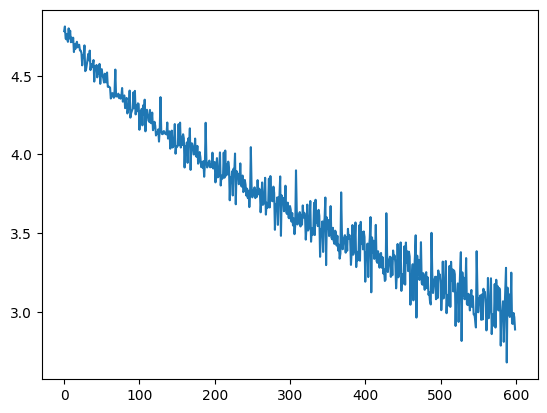

In [99]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

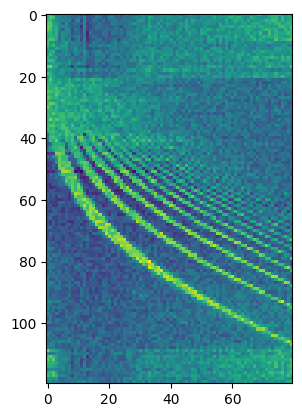

In [103]:
# layer visualization

# layer.weight.shape
plt.imshow(layer.weight.detach())

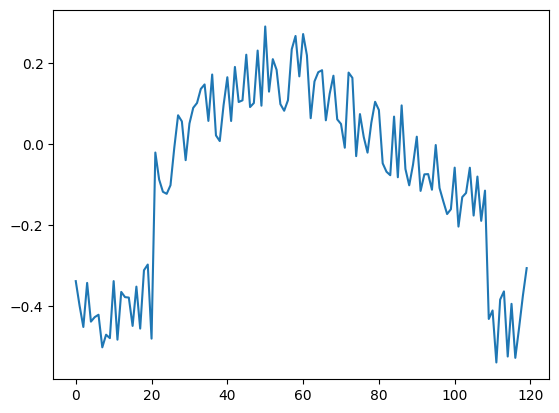

In [108]:
plt.plot(layer.bias.detach())

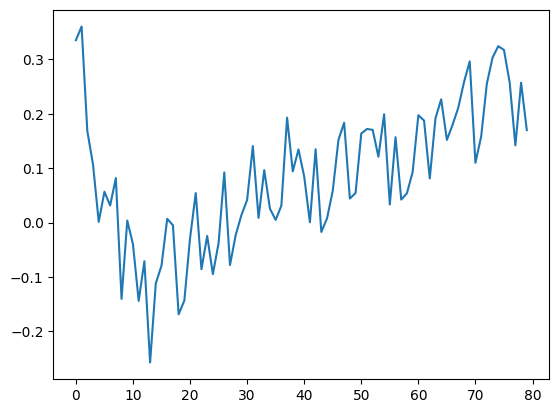

In [106]:
plt.plot(layer.weight.detach()[0])

In [91]:
correct_class_pair = []
for i, idx in enumerate(correct_class_ids):
  # print(i, idx)
  correct_class_pair.append([i, idx])
correct_class_pair

[[0, 59],
 [1, 66],
 [2, 92],
 [3, 70],
 [4, 26],
 [5, 89],
 [6, 92],
 [7, 55],
 [8, 25],
 [9, 41],
 [10, 53],
 [11, 91],
 [12, 80],
 [13, 56],
 [14, 62],
 [15, 60],
 [16, 95],
 [17, 54],
 [18, 21],
 [19, 104],
 [20, 68],
 [21, 34],
 [22, 73],
 [23, 57],
 [24, 47],
 [25, 64],
 [26, 45],
 [27, 33],
 [28, 42],
 [29, 44],
 [30, 37],
 [31, 67],
 [32, 51],
 [33, 32],
 [34, 71],
 [35, 24],
 [36, 41],
 [37, 45],
 [38, 47],
 [39, 62],
 [40, 41],
 [41, 56],
 [42, 79],
 [43, 76],
 [44, 93],
 [45, 33],
 [46, 53],
 [47, 21],
 [48, 72],
 [49, 90]]

In [74]:
len(audios), audios[0].shape, torch.cat(audios, dim=0).shape, torch.cat(audios, dim=1).shape

(50, torch.Size([1, 64000]), torch.Size([50, 64000]), torch.Size([1, 3200000]))

In [83]:
batch_fns[0].stem.split('-')

['bass_synthetic_134', '059', '100']